In [ ]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Aug  1 16:42 kaggle.json
 99% 2.28G/2.29G [00:30<00:00, 44.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.5MB/s]


In [ ]:
import os
import zipfile

local_zip = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


IMG_SIZE = 224

TRAINING_DIR = "/content/chest_xray/train"
training_datagen = ImageDataGenerator(rescale = 1./255 ,
                                      shear_range=0.5,
                                      zoom_range=0.2)
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(IMG_SIZE,IMG_SIZE) ,class_mode='categorical',
                                                       batch_size=64,shuffle=True )


TEST_DIR = "/content/chest_xray/test"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode = None , batch_size = 64,
                                                  shuffle = False)


VAL_DIR = "/content/chest_xray/val"
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE),class_mode='categorical',
                                                       batch_size=64,shuffle= False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


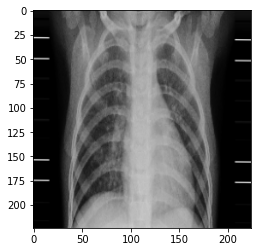

In [ ]:
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
import tensorflow_hub as hub

URL = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'#'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4' #"https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 
feature_extractor = hub.KerasLayer(URL, input_shape=(224,224,3))
feature_extractor.trainable = False

In [ ]:
model = tf.keras.models.Sequential([    
    feature_extractor,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2,activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 21,938,210
Trainable params: 135,426
Non-trainable params: 21,802,784
______________________________________

In [ ]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs['accuracy']>=0.96):
      self.model.stop_training=True

callbacks=myCallback()
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]

class_weight = {1: 0.25,
                0: 0.75}

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=METRICS )

history = model.fit(train_generator , epochs=15 , callbacks=[callbacks], validation_data=val_generator, class_weight=class_weight)

Epoch 1/15
82/82 [==============================] - 107s 1s/step - loss: 0.2078 - accuracy: 0.7074 - precision: 0.7074 - recall: 0.7074 - val_loss: 0.4818 - val_accuracy: 0.7692 - val_precision: 0.7692 - val_recall: 0.7692
Epoch 2/15
82/82 [==============================] - 105s 1s/step - loss: 0.1379 - accuracy: 0.8365 - precision: 0.8365 - recall: 0.8365 - val_loss: 0.4278 - val_accuracy: 0.8093 - val_precision: 0.8093 - val_recall: 0.8093
Epoch 3/15
82/82 [==============================] - 105s 1s/step - loss: 0.1121 - accuracy: 0.8756 - precision: 0.8756 - recall: 0.8756 - val_loss: 0.4039 - val_accuracy: 0.8237 - val_precision: 0.8237 - val_recall: 0.8237
Epoch 4/15
82/82 [==============================] - 105s 1s/step - loss: 0.1019 - accuracy: 0.8873 - precision: 0.8873 - recall: 0.8873 - val_loss: 0.4039 - val_accuracy: 0.8173 - val_precision: 0.8173 - val_recall: 0.8173
Epoch 5/15
82/82 [==============================] - 106s 1s/step - loss: 0.0910 - accuracy: 0.8993 - precisi

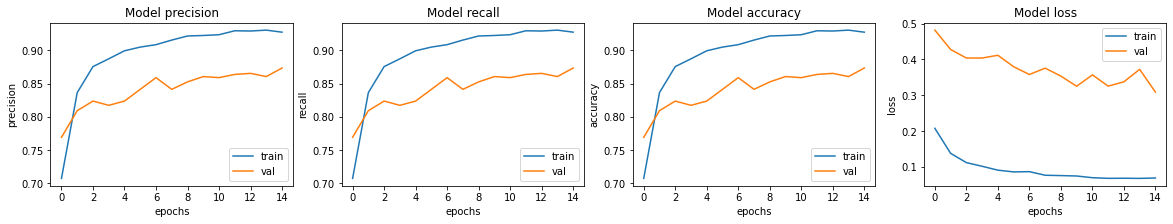

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.evaluate(val_generator)

10/10 [==============================] - 4s 449ms/step - loss: 0.3088 - accuracy: 0.8734 - precision: 0.8734 - recall: 0.8734


[0.30875563621520996,
 0.8733974099159241,
 0.8733974099159241,
 0.8733974099159241]